In [1]:
import sys
import time
import torch
from torch.utils.data import TensorDataset
import numpy as np
from matplotlib import pyplot as plt
import logging

sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, flows, distributions, training
from manifold_flow import nn as nn_

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Timing function

In [2]:
def make_data(dim, n=100):
    return torch.randn(dim*n).view(n, dim)

In [3]:
def make_model(xdim, ldim=1):
    trf = flows.vector_transforms.create_transform(
        dim=xdim,
        flow_steps=5,
        linear_transform_type="permutation",
        base_transform_type="affine-coupling",
        hidden_features=20,
        num_transform_blocks=5,
        dropout_probability=0.,
        use_batch_norm=False
    )
    return trf

In [4]:
def time_logdet(model, data, repeats=3):
    times = []
    for _ in range(repeats):
        time_before = time.time()
        _ = model(data, full_jacobian=False)
        time_after = time.time()
        
        print(time_after-time_before, "s")
        times.append(time_after-time_before)
    return np.mean(times), np.std(times)

In [5]:
def time_jacobian(model, data, repeats=3):
    times = []
    for _ in range(repeats):
        time_before = time.time()
        _ = model(data, full_jacobian=True)
        time_after = time.time()
        
        print(time_after-time_before, "s")
        times.append(time_after-time_before)
    return np.mean(times), np.std(times)

In [6]:
def run(xdim, jacobian=True):
    data = make_data(xdim)
    data.requires_grad = True
    model = make_model(xdim)
    if jacobian:
        return time_jacobian(model, data)
    else:
        return time_logdet(model, data)

## Go!

In [7]:
xdims = [2,5,10,20,50,100]

jacobian_means = []
jacobian_stds = []
det_means = []
det_stds = []

for xdim in xdims:
    print("xdim =", xdim)
    mean_jac, std_jac = run(xdim, True)
    mean_det, std_det = run(xdim, False)
    jacobian_means.append(mean_jac)
    jacobian_stds.append(std_jac)
    det_means.append(mean_det)
    det_stds.append(std_det)

xdims = np.asarray(xdims)
jacobian_means = np.asarray(jacobian_means)
jacobian_stds = np.asarray(jacobian_stds)
det_means = np.asarray(det_means)
det_stds = np.asarray(det_stds)


xdim = 2
0.5196871757507324 s
0.4990427494049072 s
0.4882469177246094 s
0.003172159194946289 s
0.003637075424194336 s
0.003532886505126953 s
xdim = 5
1.3391668796539307 s
1.3072457313537598 s
1.2999401092529297 s
0.0035507678985595703 s
0.003915071487426758 s
0.0036897659301757812 s
xdim = 10
2.5690510272979736 s
2.504009962081909 s
2.5117383003234863 s
0.003518819808959961 s
0.0036818981170654297 s
0.003635883331298828 s
xdim = 20
5.125554800033569 s
5.12296986579895 s
5.120353937149048 s
0.0035958290100097656 s
0.004023075103759766 s
0.007264137268066406 s
xdim = 50
14.707911014556885 s
14.607937097549438 s
14.61239504814148 s
0.004684925079345703 s
0.00485682487487793 s
0.004957914352416992 s
xdim = 100
32.67186117172241 s
32.51254892349243 s
32.65154480934143 s
0.006091117858886719 s
0.006250143051147461 s
0.008327007293701172 s


## Plot

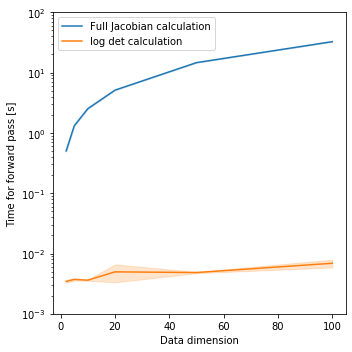

In [16]:
fig = plt.figure(figsize=(5,5))

plt.fill_between(
    xdims, jacobian_means-jacobian_stds, jacobian_means+jacobian_stds,
    color="C0", alpha=0.2
)
plt.plot(
    xdims, jacobian_means,
    c="C0", ls="-",
    label="Full Jacobian calculation"
)

plt.fill_between(
    xdims, det_means-det_stds, det_means+det_stds,
    color="C1", alpha=0.2
)
plt.plot(
    xdims, det_means,
    c="C1", ls="-",
    label="log det calculation"
)

plt.legend()

plt.xlabel("Data dimension")
plt.ylabel("Time for forward pass [s]")
plt.ylim(1.e-3,1.e2)
plt.yscale("log")

plt.tight_layout()
plt.savefig("manifold_flow_timing.pdf")
